In [1]:
import os, sys, subprocess, datetime, time
from timeit import default_timer as timer
import cv2
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
from skimage.draw import polygon
from skimage import data
from skimage.util import random_noise
import tifffile
#from skimage.feature import match_template
#import scipy.io as spio
#from scipy import ndimage as ndi
#from scipy import signal as signal
#from joblib import Parallel, delayed
%matplotlib inline

/Users/ackman/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [12]:
def importFilelist(filepath):
    #import text file of filenames as pandas dataframe
    files = pd.read_table(filepath,names=['filename','matfilename', 'age.g'],sep=' ',header=None)
    return files


def writeData(filepath,data):
    #write results dataframe by appending to file
    #filepath = 'dXcorrObs.txt'
    if os.path.isfile(filepath):
        writeHeader=False
    else:
        writeHeader=True

    with open(filepath, 'a') as f:
        data.to_csv(f, index=False, sep='\t', header=writeHeader)  #make if logic to not append with header if file already exists



def getA3binaryArray(f,region):
    #read in domainData into A3 binary array
    sz = np.int64(region['domainData']['CC/ImageSize'][:,0])
    A3 = np.zeros(sz,dtype='uint8')
    for i in np.arange(region['domainData']['CC/PixelIdxList'].shape[0]):
        pxind = np.array(f[region['domainData']['CC/PixelIdxList'][i,0]], dtype='int64')
        A3.T.flat[pxind[0,:]] = 255
    return A3


def getHemisphereMasks(f,region,A3):
    #read region['coords'] and region['name'] to get hemisphere masks
    sz = A3.shape
    leftMask = np.zeros((sz[0],sz[1]),dtype=bool)
    rightMask = np.zeros((sz[0],sz[1]),dtype=bool)
    bothMasks = np.zeros((sz[0],sz[1]),dtype=bool)
    for i in np.arange(region['name'].len()):  #this is length 33
        currentString = f[region['name'][i,0]][...].flatten().tostring().decode('UTF-16')
        if (currentString == 'cortex.L') or (currentString == 'cortex.R'):
            #print(i,currentString)
            x = np.array(f[region['coords'][i,0]],dtype='int64')[0,:]
            y = np.array(f[region['coords'][i,0]],dtype='int64')[1,:]
            x = np.append(x,x[0]) #close the polygon coords
            y = np.append(y,y[0]) #close the polygon coords
            rr, cc = polygon(y,x,bothMasks.shape)
            if currentString == 'cortex.L':
                x_L = x
                y_L = y
                leftMask[rr,cc] = True
            elif currentString == 'cortex.R':
                x_R = x
                y_R = y
                rightMask[rr,cc] = True
            bothMasks[rr,cc] = True
    return leftMask, rightMask



def getHemisphereCoords(f,region):
    for i in np.arange(region['name'].len()):  #this is length 33
            currentString = f[region['name'][i,0]][...].flatten().tostring().decode('UTF-16')
            if (currentString == 'cortex.L') or (currentString == 'cortex.R'):
                #print(i,currentString)
                x = np.array(f[region['coords'][i,0]],dtype='int32')[0,:]
                y = np.array(f[region['coords'][i,0]],dtype='int32')[1,:]
                x = np.append(x,x[0]) #close the polygon coords
                y = np.append(y,y[0]) #close the polygon coords
                if currentString == 'cortex.L':
                    xyPtsL = np.stack((x,y),axis=-1)
                elif currentString == 'cortex.R':
                    xyPtsR = np.stack((x,y),axis=-1)
    return xyPtsL, xyPtsR


def stridemask3d(mask,z):
    #make a 2D image mask into a 3D repeated image mask using numpy stride_tricks to fake the 3rd dimension
    mask3d = np.lib.stride_tricks.as_strided(
                    mask,                              # input array
                    (mask.shape[0], mask.shape[1],z),  # output dimensions
                    (mask.strides[0], mask.strides[1],0) # stride length in bytes
                )
    return mask3d


def cvblur(image,template):
    #fast gaussian blur with cv2
    image = cv2.GaussianBlur(image,(0,0),3)
    template = cv2.GaussianBlur(template,(0,0),3)
    return image, template


def cvcorr(image,template):
    #faster xcorr with cv2
    image = image.astype('float32')
    template = template.astype('float32') #cv2.filter2D needs a float as input
    c = cv2.filter2D(image,-1,template)
    corrValue = c[c.shape[0]/2,c.shape[1]/2]
    return corrValue, c


def getA3hemipshereArrays(A3,leftMask,rightMask):
    #calculate lateral column shift for a flipped right hemisphere for a common coord system
    rightMask_flip = np.fliplr(rightMask)
    IND_L = np.nonzero(leftMask) #dim2 of the tuple is the col indices
    IND_Rflip = np.nonzero(rightMask_flip) #dim2 of the tuple is the col indices
    dx = np.amax(IND_L[1]) - np.amax(IND_Rflip[1]) #number of pixesl to shift the flipped right hemisphere column indices by

    #get 3d mask arrays, new binary data arrays, and a flipped R hemi array
    leftMask3d = stridemask3d(leftMask,A3.shape[2])
    rightMask3d = stridemask3d(rightMask,A3.shape[2])

    A3left = np.logical_and(A3, leftMask3d)
    A3left = A3left.view(np.uint8)  #cast to uint8 inplace and multiply by 255 inplace
    A3left *= 255
    #np.place(A3left, A3left>0, 255)
    
    A3right = np.logical_and(A3, rightMask3d)
    A3right = np.fliplr(A3right)
    
    #make a new shifted right hemisphere array
    IND_R3d = np.nonzero(A3right) #dim2 of the tuple is the col indices
    INDnew = IND_R3d[1] + dx #add shift to column indices
    #A3right_shift = np.zeros_like(A3)
    #A3right = np.zeros_like(A3)
    A3right = A3right.view(np.uint8) #cast to uint8 inplace and multiply by 0 inplace
    #np.putmask(A3right, A3right>0, A3right*0)
    #np.place(A3right, A3right>0, 0)
    A3right *= 0
    A3right[IND_R3d[0],INDnew,IND_R3d[2]] = 255
    
    return A3left, A3right

def getCorr(A3left,A3right,i):
    image = A3left[:,:,i]
    template = A3right[:,:,i]
    image,template = cvblur(image,template)
    autoCorr = cvcorr(image,image)
    obsCorr = cvcorr(image,template)
    fr = i + 1
    return fr, autoCorr, obsCorr


def cvmatch(image,template):
    #faster xcorr with cv2
    c = cv2.matchTemplate(image,template,cv2.TM_CCORR_NORMED)
    corrValue = c[c.shape[0]/2,c.shape[1]/2]
    return corrValue

def cvmatchN(image,template):
    #faster xcorr with cv2
    c = cv2.matchTemplate(image,template,cv2.TM_CCOEFF_NORMED)
    corrValue = c[c.shape[0]/2,c.shape[1]/2]
    return corrValue


def playMovie(A3,newMinMax=False):
    #play movie in opencv
    cv2.startWindowThread()
    cv2.namedWindow("raw", cv2.WINDOW_NORMAL) #Create a resizable window
    i = 0
    
    if newMinMax:
        #im = cv2.normalize(im, None, newMinMax[0], newMinMax[1], cv2.NORM_MINMAX)
        #im = cv2.normalize(im, None, newMinMax[0], newMinMax[1], cv2.NORM_L2)
        #im = cv2.equalizeHist(im)
        #im,cdf = histeq(im)
        cv2.normalize(A3,A3,newMinMax[0],newMinMax[1])
    
    while True:
        #im = np.uint8(A3[:,:,i] * 255)
        im = A3[:,:,i]
        im = cv2.applyColorMap(im, cv2.COLORMAP_HOT)
        im = cv2.GaussianBlur(im,(0,0),3)
        #th,bw = cv2.threshold(im,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        #bw = cv2.adaptiveThreshold(im,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,5,0)
        cv2.imshow('raw',im)
        k = cv2.waitKey(10) 
        if k == 27: #if esc is pressed
            break
        if k == ord('b'):
            i -= 1000
        elif k == ord('f'):
            i += 1000
        else:
            i += 1
        if (i > (A3.shape[2]-1)) or (i < 0) :
            i = 0

    cv2.destroyAllWindows()


    
    
def histeq(im, nbr_bins=256):
    """histogram equalization of a grayscale image"""
    #get image histo
    imhist,bins = np.histogram(im.flatten(),nbr_bins,normed=True)
    cdf = imhist.cumsum() #cumulative distribution function
    cdf = 255 * cdf / cdf[-1] #normalize
    #use linear interp of cdf to find new pixel values
    im2 = np.interp(im.flatten(),bins[:-1],cdf)
    return im2.reshape(im.shape), cdf


In [19]:
def playMovieRGB(A3,pts=False,filename=False):
    #play movie in opencv
    #input is a uint8 numpy rgb array with A3.ndim = 4 and shape (x,y,z,3)
    #pts should be a list of numpy.ndarrays 'list((xyPts1,xyPts2))', since cv2.polylines() can be used to draw multiple lines if a list of arrays is passed to it.
    cv2.startWindowThread()
    cv2.namedWindow("raw", cv2.WINDOW_NORMAL) #Create a resizable window
    i = 0
    toggleNext = True
    tf = True
    #if isinstance(pts, (list, np.ndarray)):
    if isinstance(pts, (list)):
        drawCoords = True
    else:
        drawCoords = False
    
    if filename == False:
        import datetime
        filename = datetime.datetime.strftime(datetime.datetime.now(), '%Y-%m-%d-%H%M%S')
    
    while True:
        im = A3[:,:,i,:]
        img = cv2.cvtColor(im, cv2.COLOR_RGB2BGR) #convert numpy RGB input to BGR colorspace for cv2
        #img = cv2.GaussianBlur(img,(0,0),3)
        corrValue = cvmatch(img[:,:,2],img[:,:,1])
        cv2.putText(img, str(i), (5,25), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (155,155,155)) #draw frame text
        cv2.putText(img, '{0:.4f}'.format(corrValue), (img.shape[1]-150,25), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (155,155,155)) #draw frame text
        if drawCoords:
            cv2.polylines(img, pts, False,(255, 255, 255), thickness=1, lineType=cv2.CV_AA)
        cv2.imshow('raw',img)
        k = cv2.waitKey(10) 
        if k == 27: #if esc is pressed
            break
        elif (k == ord(' ')) and (toggleNext == True): #if space is pressed
                tf = False
        elif (k == ord(' ')) and (toggleNext == False): #if space is pressed
                tf = True
        toggleNext = tf #toggle the switch
        if k == ord('b') and toggleNext:
            i -= 100
        elif k == ord('f') and toggleNext:
            i += 100
        elif k == ord('>') and (toggleNext == False):
            i += 1
        elif k == ord('<') and (toggleNext == False):
            i -= 1
        elif k == ord('s') and (toggleNext == False):
            #params = list()
            #params.append(cv.CV_IMWRITE_PNG_COMPRESSION)
            #params.append(8)
            #cv2.imwrite('image{0}.png'.format(i), img, params)
            cv2.imwrite(filename + '-fr' + str(i) + '.png', img)
        elif toggleNext:
            i += 1
        
        if (i > (A3.shape[2]-1)) or (i < 0) :
            i = 0

    cv2.destroyAllWindows()



In [22]:
#matfilename = '/Users/ackman/Data/2photon/140328/2015-03-13-114620_sigma3_thresh1/140328_05_20150313-125415_d2r.mat'
matfilename = '/Users/ackman/Data/2photon/140331/2015-03-13-114620_sigma3_thresh1/140331_05_20150314-090750_d2r.mat'
#matfilename = '/Users/ackman/Data/2photon/140509/2015-03-13-114620_sigma3_thresh1/140509_22_20150313-193050_d2r.mat'
#matfilename = '/Users/ackman/Data/2photon/141125/2015-03-13-114620_sigma3_thresh1/141125_05_20150313-140653_d2r.mat'

f = h5py.File(matfilename,'r') 
region = f.get('region')
t0=timer()
A3 = getA3binaryArray(f,region); print(timer()-t0)
t0=timer()
leftMask, rightMask = getHemisphereMasks(f,region,A3); print(timer()-t0)
t0=timer()
A3left, A3right_shift = getA3hemipshereArrays(A3,leftMask,rightMask); print(timer()-t0)

t0 = timer()
A4 = np.zeros((A3left.shape[0],A3left.shape[1],A3left.shape[2],3),dtype='uint8')
A4[:,:,:,0] = A3left
A4[:,:,:,1] = A3right_shift
print(timer() - t0)
print(A4.shape)


1.4471681118
0.0267548561096
9.81771707535
10.0934360027
(540, 640, 3000, 3)


In [23]:
fn = os.path.splitext(os.path.basename(matfilename))[0]
xyPtsL,xyPtsR = getHemisphereCoords(f,region)
pts = np.stack((xyPtsL,xyPtsR),axis=2)
playMovieRGB(A4,list((xyPtsL,xyPtsR)),fn)

In [24]:
try:
    del(region, A3, leftMask, rightMask, A3left, A3right_shift, A4, images, image)
except:
    print('Variables already gone...')


Variables already gone...


/Users/ackman/anaconda/envs/py27/lib/python2.7/site-packages/tifffile/tifffile.py:1974: UserWarning: tags are not ordered by code
  warnings.warn("tags are not ordered by code")


13.4423279762
(540, 640, 3000)
float64
(345600, 3000)


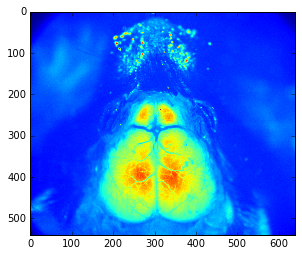

In [14]:
t0 = timer()
#fn = '/Users/ackman/Desktop/140509_21.tif'
fn = '/Users/ackman/Data/2photon/120518i/120518_07_fr1-300.tif'
with tifffile.TiffFile(fn) as tif:
    A = tif.asarray()
del(tif)
A = np.rollaxis(A, 0, 3)
A = np.float64(A)
print(timer()-t0)
print(A.shape)
print(A.dtype)
sz = A.shape

plt.imshow(A[:,:,0])
A = np.reshape(A, (A.size/sz[2], sz[2]))
print(A.shape)

This takes just 0.32 s to read in array at its ** default uint16.**
And takes 0.78 s to read in array and cast as float64.

Matlab takes 2.11 s to read in same array into a float64.


In [15]:
t0=timer()
Amean = np.mean(A,axis=1)
Amean2D = np.lib.stride_tricks.as_strided(Amean, (Amean.shape[0],A.shape[1]),(Amean.strides[0],0))
A /= Amean2D
A -= 1
print(timer()-t0)



13.2841491699


In [16]:
A += abs(np.amin(A))
A /= np.amax(A)
A = np.reshape(A,sz)

Without stride tricks, the above F/F0-1 sequence was slower than matlab (2s vs 1s). With stride tricks we get 0.44 s, a big improvement. 

In [17]:
t0=timer()
meanA = np.mean(A) 
stdA = np.std(A)
newMin = meanA - 2*stdA
newMax = meanA + 5*stdA
#playMovie(A2,(newMin,newMax))
print(timer()-t0)

t0=timer()
A -= newMin
A *= 255.0/(newMax-newMin)
print(timer()-t0)

t0=timer()
#np.clip(A, 0, 255, out=A)
A.clip(0, 255) #faster than the documented np.clip(A,min,max,out=A) which should be inplace. Possible version/memory leak issue
print(timer()-t0)



55.4744589329
22.1628820896
75.272135973


A2[logical]: 1.28217601776

np.clip: 1.14894986153


In [18]:
playMovie(np.uint8(A))

In [20]:
del(A,Amean,Amean2D)

In [25]:
%whos

Variable                Type                          Data/Info
---------------------------------------------------------------
cv2                     module                        <module 'cv2' from '/User<...>.7/site-packages/cv2.so'>
cvblur                  function                      <function cvblur at 0x11e318488>
cvcorr                  function                      <function cvcorr at 0x11e318de8>
cvmatch                 function                      <function cvmatch at 0x11e318140>
cvmatchN                function                      <function cvmatchN at 0x11e318050>
data                    module                        <module 'skimage.data' fr<...>image/data/__init__.pyc'>
datetime                module                        <module 'datetime' from '<...>lib-dynload/datetime.so'>
f                       File                          <HDF5 file "140331_05_201<...>090750_d2r.mat" (mode r)>
fn                      str                           140331_05_20150314-090750_d